# Introduction to Clustering with MNIST

CHECK LIST:

[] falar sobre as métricas para um modelo de clustering

## 1. Imports

### Preliminary Explanations

**mnist**: is a database with 70,000 images of numbers between 0 and 9, written by hand.

**Keras**: is a high-level deep learning library written in Python, providing a user-friendly interface to create, train, and deploy deep learning models. 

**Sklearn**: is a popular machine learning library in Python that provides a wide range of tools and algorithms for data preprocessing, feature selection, model training, and evaluation.

**MiniBatchKMeans**: is a variant of the K-means clustering algorithm, which is used for unsupervised clustering of data. Unlike the traditional K-means algorithm, which uses the entire dataset to update cluster centroids, MiniBatchKMeans operates on mini-batches of the data. It is faster and more scalable than the standard K-means algorithm, making it suitable for large datasets. 

**homogeneity_score**:  is a metric used to evaluate the quality of clustering results. It measures the extent to which each cluster contains only data points from a single class or category.

**silhouette_score**: is a metric used to assess the quality of clustering results by measuring how well-separated clusters are and how similar data points are within their own cluster compared to other clusters.

**accuracy_score**: is a metric used to evaluate the performance of classification models. It measures the percentage of correctly predicted labels compared to the total number of samples.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import homogeneity_score, accuracy_score, pairwise_distances_argmin, silhouette_score
from keras.datasets import mnist as mnist_k
import matplotlib.pyplot as plt

## What is the MNIST dataset? 

The MNIST dataset is a popular dataset of handwritten digits commonly used for training and testing machine learning models in the field of computer vision. It consists of a training set of 60,000 images and a test set of 10,000 images, each of which is a grayscale image of size 28x28 pixels. The images are labeled with the corresponding digit they represent, ranging from 0 to 9. The dataset is widely used as a benchmark for image classification tasks and has played a key role in advancing the field of computer vision.

**IMPORTANT**: The MNIST dataset is the same in both Keras and Scikit-learn, but they are packaged and loaded in different ways.

* **Keras**: the MNIST dataset is loaded as a set of four NumPy arrays: train images, train labels, test images, and test labels. 
The images are 28x28 grayscale images, and the labels are integer values representing the digit in the image.
* **Scikit-learn**: the MNIST dataset is loaded as a single 2D array of shape (n_samples, n_features), where n_samples is the number of images and n_features is the number of pixels in each image. 
The pixel values are flattened into a single row and scaled to the range [0, 1]. The labels are provided as a separate 1D array of length n_samples.

For this project, Keras was chosen for its simplicity and efficiency.

In [ ]:
# LOADING MNIST from KERAS
dataset_mnist = mnist_k.load_data()

print('KERAS mnist datatype: {}'.format(type(dataset_mnist)))
print('KERAS mnist number of elements: {}'.format(len(dataset_mnist)))

11490434/11490434 [==============================] - 0s 0us/step
KERAS mnist datatype: <class 'tuple'>
KERAS mnist number of elements: 2


## Splitting Data and Prior Analysis

In [ ]:
# Splitting data into sets for training and testing
# X representents the images samples and y represents the labels
(X_train, y_train), (X_test, y_test) = dataset_mnist

print('Training Data: {}'.format(X_train.shape))
print('Training Labels: {}'.format(y_train.shape))
print('Testing Data: {}'.format(X_test.shape))
print('Testing Labels: {}'.format(y_test.shape))

Training Data: (60000, 28, 28)
Training Labels: (60000,)
Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


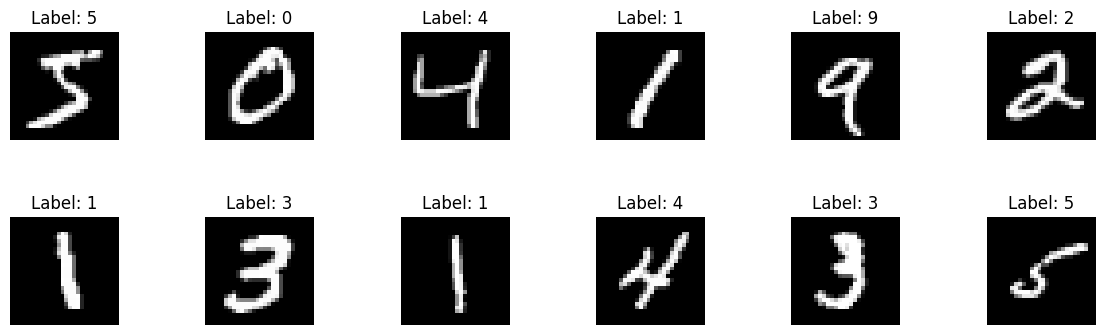

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(14, 4))
fig.subplots_adjust(hspace = 0.5, wspace=0.8)
for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(X_train[i], cmap='gray')
        ax.set_title(f"Label: {y_train[i]}")
        ax.axis('off')
plt.show()

In [ ]:
# concatenate the arrays with the labels
labels = np.concatenate([y_train, y_test])
print('Labels: {}'.format(labels.shape))

Labels: (70000,)


In [ ]:
# convert numpy array to pandas series
labels_sr = pd.Series(labels)
labels_train = pd.Series(y_train)
labels_test = pd.Series(y_test)

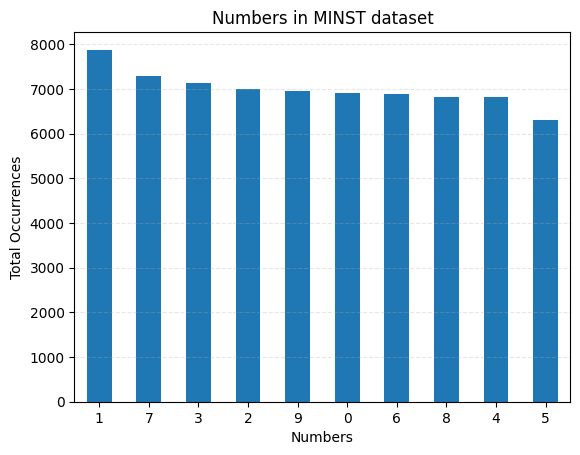

In [ ]:
# occurrences of each value present in the MNIST dataset
labels_values = labels_sr.value_counts()

ax = labels_values.plot.bar(rot=0, alpha=1)
plt.title("Numbers in MINST dataset")
plt.xlabel("Numbers")
plt.ylabel("Total Occurrences")
plt.grid(axis = 'y', linestyle='--', alpha=0.3)

In [ ]:
print(labels_train.value_counts().sort_index())
labels_train_vls = labels_train.value_counts().sort_index()
labels_test_vls = labels_test.value_counts().sort_index()

0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
dtype: int64


In [ ]:
total_labels = len(labels_sr)

# proportion of each value of the total (total occurrence * 100 /TOTAL)
prop_train = []
for item in labels_train_vls:
  prop = (item * 100) / len(y_train)
  prop_train.append(prop)

prop_train_sr = pd.Series(prop_train)

prop_test = []
for item in labels_test_vls:
  prop = (item * 100) / len(y_test)
  prop_test.append(prop)

prop_test_sr = pd.Series(prop_test)

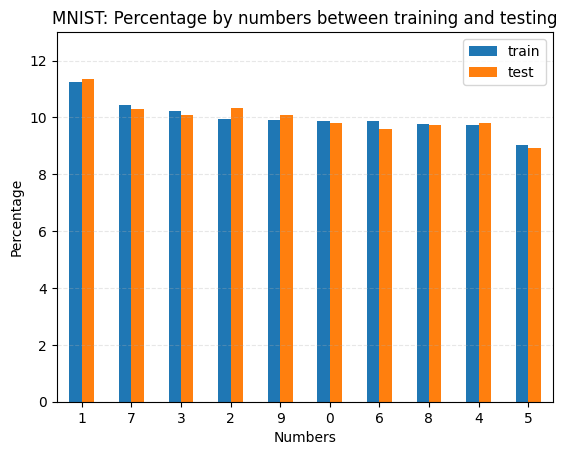

In [ ]:
# Building a dataframe with the two Series and organizing the values according to frequency in descending order
df = pd.DataFrame({
    'train': prop_train_sr,
    'test': prop_test_sr
}).sort_values(by=['train'], ascending=False)

ax = df.plot.bar(rot=0, alpha=1)

plt.ylim([0, 13])
plt.title("MNIST: Percentage by numbers between training and testing")
plt.xlabel("Numbers")
plt.ylabel("Percentage")
plt.grid(axis = 'y', linestyle='--', alpha=0.3)

## Preprocessing

**Normalization** is the process of rescaling the features to a range between 0 and 1, or -1 and 1. It is useful when the features have different scales, and we want to avoid any feature dominating the others.

In [ ]:
'''
Reshape and normalize the input data: The input data is a 3D array of shape 
(num_samples, 28, 28) where each pixel is an integer value between 0 and 255.
We need to reshape the data into a 2D array of shape where each pixel is a 
float value between 0 and 1.
'''

print('X_train TYPE: {}'.format(type(X_train)))
print('X_train DIMENSIONS: {}'.format(X_train.ndim))
print('X_train SHAPE: {}'.format(X_train.shape))

# convert images to 1 dimensional array
X_train_flatten = X_train.reshape(len(X_train), -1)

# normalization (0 - 1)
X_train_flatten = X_train_flatten.astype(float) / 255.

print('\nConversion to 1 dimensional array and normalization')
print('\nX_train_flatten TYPE: {}'.format(type(X_train_flatten)))
print('X_train_flatten DIMENSIONS: {}'.format(X_train_flatten.ndim))
print('X_train_flatten SHAPE: {}'.format(X_train_flatten.shape))

X_train TYPE: <class 'numpy.ndarray'>
X_train DIMENSIONS: 3
X_train SHAPE: (60000, 28, 28)

Conversion to 1 dimensional array and normalization

X_train_flatten TYPE: <class 'numpy.ndarray'>
X_train_flatten DIMENSIONS: 2
X_train_flatten SHAPE: (60000, 784)


## MiniBatchKMeans and K-MEANS

K-means and MiniBatchKMeans are both clustering algorithms used to group data points into clusters based on their similarity. However, there are some differences between the two:

*  **Speed**: MiniBatchKMeans is generally faster than K-means, as it processes small random batches of data points at a time rather than the entire dataset.
*  **Memory usage**: K-means requires more memory than MiniBatchKMeans as it stores all the data points in memory during each iteration. MiniBatchKMeans, on the other hand, only stores a small batch of data points in memory during each iteration.
*  **Clustering quality**: K-means generally produces more accurate clusters than MiniBatchKMeans, especially when the dataset is relatively small.
*  **Reproducibility**: K-means is deterministic, meaning that it will always produce the same clusters for a given set of inputs. MiniBatchKMeans, on the other hand, is non-deterministic, meaning that it may produce different clusters for the same inputs due to the randomness involved in the batch selection process.

Overall, the choice between K-means and MiniBatchKMeans depends on the specific requirements of the task at hand. If speed and memory usage are important considerations, MiniBatchKMeans may be the better option. However, if clustering quality and reproducibility are more important, K-means may be the better choice.

In [ ]:
# automatizando o processo de identificar o número de elementos diferentes
n_digits = len(np.unique(y_train))
print('Number of digits: {}'.format(n_digits))

MBKM = MiniBatchKMeans(n_clusters=n_digits, random_state=42)

# n_clusters: is the number of clusters
# random_state: ensure that the same random numbers are used each time the code is run

Number of digits: 10


* **fit**: This is a method used for *training a model* on a given dataset. It estimates the parameters of the model based on the input data.
* **transform**: This is a method used for transforming the input data based on the parameters learned during training. It is typically used for *preprocessing data after fitting a model*.
* **predict**: This is a method used for *making predictions on new data based on the parameters learned during training*. It is typically used for supervised learning algorithms such as regression or classification.
* **fit_transform**: This is a method used for *training a model and transforming the input data simultaneously*. It is typically used for preprocessing data before fitting a model.
* **fit_predict**: This is a method used for *training a model on a given dataset and predicting* the cluster assignments for each data point.

In [ ]:
# model training

MBKM.fit(X_train_flatten)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(n_clusters=10, random_state=42)

In [ ]:
# treinamento e previsão das imagens que foram pré-processadas

y_pred = MBKM.predict(X_train_flatten)

In [ ]:
# PREDICTING

def infer_cluster_labels(model, true_labels):
    inferred_labels = {}

    for i in range(model.n_clusters):

        # find the index of each points in cluster
        labels = []
        index = np.where(model.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(true_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

infered_labels = infer_cluster_labels(MBKM, y_train)
X_clusters = MBKM.predict(X_train_flatten)
predicted_labels = infer_data_labels(X_clusters, infered_labels)

print(predicted_labels[:20])
print(y_train[:20])



[3 0 4 1 9 2 1 3 1 7 3 1 3 6 1 7 2 7 6 7]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


## Evaluating the Model

The choice of metric depends on the specific problem and the type of data being analyzed.

Some of the metrics used to group models:

* **Accurarcy**: is a measure of how well the clustering algorithm assigns each data point to its correct cluster label.
* **Inertia**: is a measure of how compact and well-separated the clusters are. It is calculated as the sum of squared distances of each point to its closest cluster center. The lower the inertia score, the better the clustering.
* **Homogeneity score**: measures whether each cluster contains only members of a single class.
* **Completeness score**: measures whether all members of a given class are assigned to the same cluster.
* **Silhouette score**: measures how similar an object is to its own cluster compared to other clusters.
* **Adjusted Rand Index (ARI)**: measures the similarity between the true labels and predicted labels, taking into account the possibility of random clustering.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 10


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 16


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 37


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 68


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 149


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 250


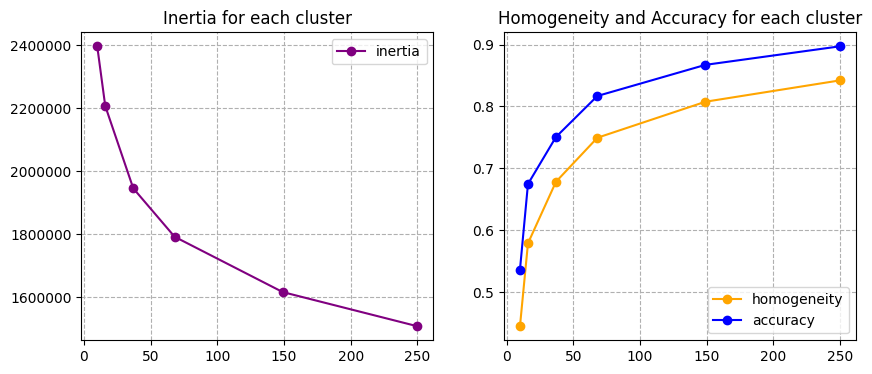

In [ ]:
def calc_metrics(estimator, data, labels):
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    # Inertia
    inertia = estimator.inertia_
    # Homogeneity Score
    homogeneity = homogeneity_score(labels, estimator.labels_)
    return inertia, homogeneity

'''
It is important to point out that although it is previously 
known that MNIST contains 10 types of digits, to test the accuracy of the model 
it is necessary to use other values for the number of clusters.
'''

clusters = [10, 16, 37, 68, 149, 250]
iner_list = []
homo_list = []
acc_list = []

for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters=n_clusters)
    estimator.fit(X_train_flatten)
    
    inertia, homo = calc_metrics(estimator, X_train_flatten, y_train)
    iner_list.append(inertia)
    homo_list.append(homo)
    
    # Determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, y_train)
    prediction = infer_data_labels(estimator.labels_, cluster_labels)
    
    acc = accuracy_score(y_train, prediction)
    acc_list.append(acc)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(clusters, iner_list, label='inertia', color='purple', marker='o')
ax[1].plot(clusters, homo_list, label='homogeneity', color='orange', marker='o')
ax[1].plot(clusters, acc_list, label='accuracy', color='blue', marker='o')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[0].grid('on', linestyle = 'dashed')
ax[1].grid('on', linestyle = 'dashed')
ax[0].set_title('Inertia for each cluster')
ax[1].set_title('Homogeneity and Accuracy for each cluster')
ax[0].ticklabel_format(style='plain')
plt.show()


In [ ]:
# visualizing MNIST with t-SNE
from sklearn.manifold import TSNE

X_samples = pd.DataFrame(X_train_flatten).sample(frac=0.1, random_state=10).reset_index(drop=True)
y_samples = pd.DataFrame(y_train).sample(frac=0.1, random_state=10).reset_index(drop=True)
# frac= is the sample size 0.1 = 10%
# random_state
# reset_index(drop=True) is used to reset the DataFrame's index


df = X_samples

tsne = TSNE(n_iter=300) # n_iter= is the number of iterations
tsne_results = tsne.fit_transform(df.values)

df['label'] = pd.DataFrame(y_samples)

t-SNE done! Time elapsed: 59.229997396469116 seconds


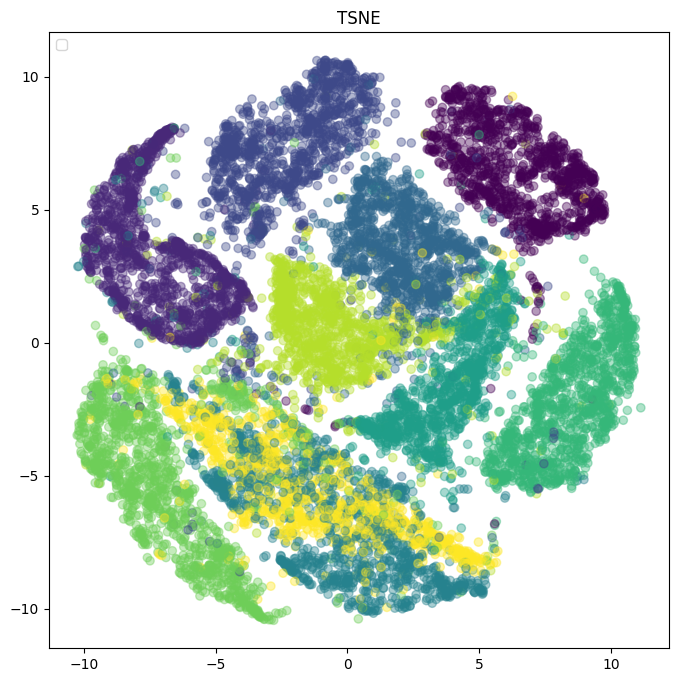

In [ ]:
%matplotlib inline
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1, title='TSNE' )
ax.scatter(
    x=tsne_results[:,0], 
    y=tsne_results[:,1], 
    c=df['label'],
    alpha=0.4)
plt.legend()
plt.show()